# Segmentation 3D d’IRM cérébrale par réseau de neurones U-Net avec mécanisme d’attention

## 📦 Importation des bibliothèques

Cette cellule importe l'ensemble des bibliothèques nécessaires à la détection de tumeurs cérébrales en 3D. Voici le rôle de chaque module :

- `numpy` : pour la manipulation efficace de tableaux multidimensionnels, essentiel pour les images médicales en 3D.
- `nibabel` : permet de lire et d’écrire des fichiers d’imagerie médicale au format NIfTI (`.nii`, `.nii.gz`), couramment utilisés en neuroimagerie.
- `glob` et `os` : pour la gestion des chemins de fichiers et la recherche dans les dossiers contenant les données.
- `tensorflow.keras.utils.to_categorical` : convertit des étiquettes en vecteurs one-hot pour les modèles de classification.
- `MinMaxScaler` de `sklearn.preprocessing` : normalise les données pour que chaque voxel soit compris entre 0 et 1, ce qui facilite l’apprentissage.
- `tensorflow` : bibliothèque principale utilisée pour la création et l’entraînement de modèles d’apprentissage profond.

### 📐 Réseau de neurones convolutionnel 3D (3D-CNN)

Les couches suivantes sont importées pour construire une architecture de type **U-Net 3D**, idéale pour la segmentation d’images volumétriques :
- `Input`, `Conv3D`, `MaxPooling3D`, `Conv3DTranspose`, `concatenate` : construction du réseau convolutionnel en 3 dimensions.
- `BatchNormalization`, `Dropout` : techniques de régularisation pour améliorer la généralisation du modèle.
- `Adam` : algorithme d’optimisation souvent utilisé dans les modèles de deep learning.
- `EarlyStopping`, `ModelCheckpoint`, `ReduceLROnPlateau` : callbacks utiles pour l'entraînement du modèle :
  - `EarlyStopping` : arrête l’entraînement si la performance sur les données de validation cesse de s’améliorer.
  - `ModelCheckpoint` : sauvegarde automatiquement le meilleur modèle.
  - `ReduceLROnPlateau` : réduit le taux d’apprentissage si la performance stagne.

---


In [16]:
import numpy as np
import nibabel as nib
import glob
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## 📁 Définition du chemin vers le jeu de données

```python
DATASET_PATH = 'BraTS2020_Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'


In [17]:

# Define dataset path (update to your local dataset path)
DATASET_PATH = 'BraTS2020_Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

## ✅ Vérification de l'existence du chemin du jeu de données

Avant de poursuivre, on vérifie que le chemin défini pour le jeu de données existe bien :



In [18]:
# Verify paths exist
print(f"Checking training data path: {DATASET_PATH}", flush=True)
if os.path.exists(DATASET_PATH):
    print("Data path exists.", flush=True)
else:
    print(f"Error: data path '{DATASET_PATH}' does not exist.", flush=True)
    exit(1)

Checking training data path: BraTS2020_Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/
Data path exists.


## 📂 Chargement des fichiers d'entraînement et de validation


In [19]:
# Get list of training and validation files (limited to 30 train, 5 val for low resources)
train_files = glob.glob(os.path.join(DATASET_PATH, 'BraTS20_Training_*'))[:100]
val_files = glob.glob(os.path.join(DATASET_PATH, 'BraTS20_Training_*'))[100:120]

print(f"Found {len(train_files)} training folders.", flush=True)
print(f"Found {len(val_files)} validation folders.", flush=True)

if len(train_files) == 0:
    print("Error: No training folders found. Check the path or folder naming.", flush=True)
    exit(1)

Found 100 training folders.
Found 20 validation folders.


## 🧼 Fonction de chargement et prétraitement d'une image IRM

Cette fonction charge une image IRM 3D correspondant à une modalité spécifique (`flair`, `t1`, `t1ce`, `t2`), puis la prépare pour le modèle de détection des tumeurs.

In [20]:
def load_and_preprocess_image(file_path, modality):
    """
    Load and preprocess a single MRI modality image.
    Args:
        file_path (str): Path to the image folder.
        modality (str): MRI modality (e.g., 'flair', 't1', 't1ce', 't2').
    Returns:
        np.array: Normalized and cropped image (128x128x128).
    """
    img_path = os.path.join(file_path, f'{os.path.basename(file_path)}_{modality}.nii')
    img = nib.load(img_path).get_fdata()
    
    # Create a new scaler instance each time and fit it to the data
    # This fixes the 'scale_' attribute error by ensuring fit() is called before transform()
    scaler = MinMaxScaler()
    img = scaler.fit_transform(img.reshape(-1, 1)).reshape(img.shape)
    
    # Crop to 128x128x128 to reduce memory usage
    img = img[56:184, 56:184, 13:141]
    return img

## 🏷️ Fonction de chargement et prétraitement du masque de segmentation

Cette fonction charge et prépare le masque de segmentation correspondant à l'image IRM d'un patient. Ce masque indique les différentes zones du cerveau, notamment la tumeur et ses sous-régions.

## Qu'est-ce qu'un **mask** (masque) dans la segmentation d'images médicales ?

### Définition

Un **mask** est une image ou un volume (dans notre cas un volume 3D) qui sert à **indiquer quelles parties de l'image correspondent à des régions d'intérêt spécifiques**.

Dans la segmentation des tumeurs cérébrales, ce mask est une **annotation manuelle ou semi-automatique** qui identifie pour chaque voxel (pixel 3D) s'il appartient :

- À une région saine du cerveau (pas de tumeur),
- À une tumeur, et si oui, à quel type de tissu tumoral.

---

### Comment ça fonctionne ?

- Chaque voxel du volume est associé à une **étiquette (label)** indiquant sa classe.
- Par exemple, dans notre cas, on peut avoir plusieurs classes :
  - **0** : tissu sain / fond (pas de tumeur),
  - **1** : tissu de tumeur de type A (par exemple, tumeur « edema »),
  - **2** : tissu de tumeur de type B (par exemple, « enhancing tumor »),
  - **3** : tissu de tumeur de type C (par exemple, « necrotic tumor core »).

---

### Représentation du mask dans le code

- Le mask original est une matrice 3D (128x128x128) où chaque voxel a une valeur entière correspondant à la classe (0, 1, 2, 3).
- Cette matrice est ensuite **convertie en format one-hot encoding**, ce qui signifie qu’elle devient une matrice 4D `(128, 128, 128, 4)` où la dernière dimension est un vecteur de longueur 4 indiquant la probabilité d'appartenance du voxel à chacune des classes.

---

### Exemple concret

Pour un voxel donné :

| Classe | Code entier | One-hot encoding (vecteur 4D) |
|--------|-------------|-------------------------------|
| Fond (pas de tumeur) | 0 | [1, 0, 0, 0] |
| Tumeur type A | 1 | [0, 1, 0, 0] |
| Tumeur type B | 2 | [0, 0, 1, 0] |
| Tumeur type C | 3 | [0, 0, 0, 1] |

---

### Pourquoi utiliser le mask ?

- Pendant l’entraînement du modèle de segmentation, ce mask sert de **vérité terrain (ground truth)**.
- Le modèle apprend à prédire pour chaque voxel la bonne classe en comparant ses sorties avec ce mask.
- Cela permet d’évaluer la performance et d’ajuster les paramètres du modèle.

---

### Dans notre cas 
Tous les voxels étiquetés avec la classe 4 sont réassignés à la classe 3.

Cela simplifie la classification en réduisant le nombre de classes.


In [21]:
def load_and_preprocess_mask(file_path):
    """
    Load and preprocess segmentation mask.
    Args:
        file_path (str): Path to the image folder.
    Returns:
        np.array: One-hot encoded mask (128x128x128x4).
    """
    mask_path = os.path.join(file_path, f'{os.path.basename(file_path)}_seg.nii')
    mask = nib.load(mask_path).get_fdata()
    mask = mask.astype(np.uint8)  # Convert to uint8 for label encoding
    mask[mask == 4] = 3  # Reassign label 4 to 3
    mask = mask[56:184, 56:184, 13:141]
    # Convert to one-hot encoding and cast to float32 to match model output
    mask = to_categorical(mask, num_classes=4).astype(np.float32)
    return mask

## 🔄 Générateur de données par batch pour l'entraînement et la validation

Cette fonction est un **générateur Python** qui charge les images IRM et leurs masques de segmentation par petits lots (batchs) afin d’économiser la mémoire et faciliter l’entraînement du modèle.
### Interprétation des résultats attendus
Ce générateur permet d’alimenter le modèle par petites quantités de données à la fois, évitant de saturer la mémoire RAM/GPU.

Les images multi-canaux (modalités) donnent une représentation riche des tissus cérébraux, essentielle pour une bonne détection des tumeurs.

Les masques one-hot fournissent une supervision claire au modèle pour apprendre à segmenter les différentes zones tumorales.

Pendant l’entraînement, on s’attend à voir le modèle s’améliorer en détectant précisément les contours et sous-types de tumeurs, grâce à ces données bien préparées.

In [22]:

def data_generator(files, batch_size=1, include_masks=True):
    """
    Generator for loading data in batches to save memory.
    Args:
        files (list): List of file paths.
        batch_size (int): Number of samples per batch.
        include_masks (bool): Whether to load masks (False for validation data without masks).
    Yields:
        tuple: Batch of images (batch_size, 128, 128, 128, 4) and masks (batch_size, 128, 128, 128, 4) if include_masks is True.
    """
    while True:
        np.random.shuffle(files)
        for start in range(0, len(files), batch_size):
            end = min(start + batch_size, len(files))
            batch_files = files[start:end]
            
            print(f"Processing batch {start + 1}/{len(files)}", flush=True)
            
            images = []
            masks = []
            for file in batch_files:
                # Debug: Print the file paths for the first file
                if start == 0 and len(images) == 0:
                    print(f"Loading files from: {file}", flush=True)
                    print(f"Example t1ce path: {os.path.join(file, f'{os.path.basename(file)}_t1ce.nii')}", flush=True)
                    if include_masks:
                        print(f"Example seg path: {os.path.join(file, f'{os.path.basename(file)}_seg.nii')}", flush=True)
                
                # Load and stack modalities
                flair = load_and_preprocess_image(file, 'flair')
                t1 = load_and_preprocess_image(file, 't1')
                t1ce = load_and_preprocess_image(file, 't1ce')
                t2 = load_and_preprocess_image(file, 't2')
                img = np.stack([flair, t1, t1ce, t2], axis=-1)
                images.append(img)
                
                if include_masks:
                    mask = load_and_preprocess_mask(file)
                    masks.append(mask)
            
            if include_masks:
                yield np.array(images), np.array(masks)
            else:
                yield np.array(images)

## Fonction `attention_gate` — Mécanisme d'attention dans le modèle 3D

### Qu'est-ce que c'est ?

Cette fonction implémente un **module d'attention** utilisé dans les architectures de réseaux de neurones convolutionnels, particulièrement dans les U-Net attentionnels pour la segmentation d’images médicales.

---

### Objectif du module d'attention

- **Focaliser le réseau sur les régions importantes** des images, ici les zones où la tumeur est présente.
- Ignorer ou diminuer le poids des régions non pertinentes, afin d'améliorer la précision de la segmentation.
- Cela aide le réseau à mieux capturer les détails complexes et à réduire le bruit.

---

### Comment fonctionne ce `attention_gate` ?

- Il prend deux entrées :
  - `x` : la sortie d’une couche antérieure (skip connection) qui contient des caractéristiques détaillées mais non filtrées.
  - `g` : un signal de contrôle provenant de la partie "décodage" (decoder) du réseau, qui donne un contexte global.
  
- Ces deux signaux sont d'abord projetés via des convolutions 3D (`Conv3D`) avec un filtre de taille 1x1x1 pour réduire la dimensionnalité tout en gardant l'information importante.
  
- Ensuite, on additionne (`Add`) les deux projections, on applique une activation ReLU pour introduire la non-linéarité, puis une nouvelle convolution 1x1x1 suivie d'une activation sigmoïde.
  
- L’activation sigmoïde produit une **carte d’attention** : un masque de valeurs entre 0 et 1 qui représente à quel point chaque voxel doit être « mis en avant ».
  
- Finalement, ce masque est multiplié (`Multiply`) élément par élément avec l’entrée originale `x`, ce qui **filtre et amplifie les caractéristiques importantes** tout en supprimant les caractéristiques non pertinentes.

---

### Pourquoi c’est utile dans la détection de tumeurs cérébrales ?

- Le cerveau est complexe et contient beaucoup de structures similaires.
- Les tumeurs peuvent être petites ou dispersées.
- Le mécanisme d’attention aide le réseau à **se concentrer uniquement sur les régions avec des caractéristiques significatives liées à la tumeur**, améliorant ainsi la qualité de la segmentation.
  
---

### Interprétation des résultats

- Une bonne carte d'attention indiquera que le réseau **attribue un poids élevé aux régions tumorales**.
- On peut visualiser cette carte pour comprendre quelles parties du volume le réseau considère importantes.
- Cela rend le modèle plus interprétable et plus performant en réduisant les faux positifs dans les zones non tumorales.

---

### En résumé

Le `attention_gate` agit comme un filtre intelligent qui oriente le réseau pour qu'il **regarde au bon endroit**, améliorant ainsi la capacité à détecter et segmenter précisément les tumeurs cérébrales dans les images 3D.



In [23]:
def attention_gate(x, g, filters):
    """
    Attention gate to focus on relevant features.
    Args:
        x (tensor): Skip connection input.
        g (tensor): Gating signal from decoder.
        filters (int): Number of filters.
    Returns:
        tensor: Attention-weighted output.
    """
    x1 = Conv3D(filters, 1, padding='same')(x)
    g1 = Conv3D(filters, 1, padding='same')(g)
    out = tf.keras.layers.Add()([x1, g1])
    out = tf.keras.layers.Activation('relu')(out)
    out = Conv3D(1, 1, padding='same')(out)
    out = tf.keras.layers.Activation('sigmoid')(out)
    return tf.keras.layers.Multiply()([x, out])


## Architecture U-Net 3D avec Attention

### Description générale

Cette fonction définit un modèle **U-Net 3D avec des mécanismes d'attention** pour la segmentation multi-classes (4 classes ici), adapté à des volumes médicaux comme les IRM cérébrales.

---

### Structure du réseau

1. **Entrée**
   - Volume 3D avec 4 canaux (les 4 modalités IRM : FLAIR, T1, T1ce, T2).
   - Taille : `(128, 128, 128, 4)`.

2. **Encodeur (Compression)**
   - Trois blocs de convolution 3D suivis de Batch Normalization et ReLU.
   - À chaque bloc, on applique un max-pooling 3D (2x2x2) pour réduire la résolution spatiale par 2.
   - Le nombre de filtres double à chaque étape (8 → 16 → 32), ce qui permet d'extraire des caractéristiques de plus en plus complexes et abstraites.

3. **Bottleneck (col du réseau)**
   - Deux convolutions 3D avec 64 filtres pour apprendre les représentations les plus profondes et abstraites des données.

4. **Décodeur (Upsampling) avec Attention**
   - À chaque étape du décodeur :
     - On fait une convolution transpose 3D pour augmenter la résolution spatiale (upsampling).
     - On applique un **mécanisme d’attention** (`attention_gate`) qui filtre les caractéristiques importantes dans la skip connection correspondante issue de l’encodeur.
     - On concatène les caractéristiques upsamplées et les caractéristiques "filtrées" par l'attention.
     - Deux convolutions 3D suivent pour affiner la représentation.
   - Le nombre de filtres diminue progressivement (32 → 16 → 8), ramenant la résolution spatiale à celle de l'entrée.

5. **Sortie**
   - Une dernière convolution 3D avec `num_classes=4` filtres et activation `softmax` produit des probabilités de classes pour chaque voxel du volume.
   - Chaque voxel est classifié comme appartenant à une des 4 classes (fonds, œdème, tumeur, nécrose, par exemple).

---

### Pourquoi utiliser l'attention dans le U-Net 3D ?

- Le U-Net classique utilise des skip connections pour récupérer des détails spatiaux de l’encodeur vers le décodeur.
- Ici, l'attention permet de **moduler l'information transmise par les skip connections** en mettant l'accent uniquement sur les caractéristiques les plus pertinentes.
- Cela améliore la précision de segmentation en réduisant le bruit provenant de zones non importantes.
- Essentiel dans les images médicales où les tumeurs peuvent être petites et difficiles à distinguer.

---

### Interprétation et avantages du modèle

- Le modèle peut segmenter automatiquement des images 3D complexes en différenciant plusieurs tissus ou structures.
- L’attention favorise une meilleure localisation des tumeurs et une meilleure délimitation des contours.
- En réduisant le nombre de filtres (8-16-32-64) on optimise l’utilisation des ressources (mémoire CPU/GPU) tout en gardant une bonne capacité d’apprentissage.
- La sortie softmax permet une prédiction probabiliste pour chaque classe, facilitant la quantification de l'incertitude.

---

### En résumé

Ce U-Net 3D avec attention est un outil puissant pour la segmentation médicale volumique, combinant :
- Extraction hiérarchique des caractéristiques 3D,
- Mécanismes d'attention pour focaliser sur les régions importantes,
- Une architecture symétrique encodeur-décodeur pour la reconstruction précise des segmentations.



In [24]:
def unet_3d_attention(input_shape=(128, 128, 128, 4), num_classes=4):
    """
    Define 3D U-Net with Attention model.
    Args:
        input_shape (tuple): Input shape (128, 128, 128, 4).
        num_classes (int): Number of output classes (4).
    Returns:
        Model: Compiled Keras model.
    """
    inputs = Input(input_shape)
    
    # Encoder (reduced filters for CPU)
    c1 = Conv3D(8, 3, activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv3D(8, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling3D(pool_size=(2, 2, 2))(c1)
    
    c2 = Conv3D(16, 3, activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv3D(16, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling3D(pool_size=(2, 2, 2))(c2)
    
    c3 = Conv3D(32, 3, activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv3D(32, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling3D(pool_size=(2, 2, 2))(c3)
    
    # Bottleneck
    c4 = Conv3D(64, 3, activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv3D(64, 3, activation='relu', padding='same')(c4)
    
    # Decoder with Attention
    u3 = Conv3DTranspose(32, 2, strides=(2, 2, 2), padding='same')(c4)
    a3 = attention_gate(c3, u3, 32)
    u3 = concatenate([u3, a3])
    c5 = Conv3D(32, 3, activation='relu', padding='same')(u3)
    c5 = BatchNormalization()(c5)
    c5 = Conv3D(32, 3, activation='relu', padding='same')(c5)
    
    u2 = Conv3DTranspose(16, 2, strides=(2, 2, 2), padding='same')(c5)
    a2 = attention_gate(c2, u2, 16)
    u2 = concatenate([u2, a2])
    c6 = Conv3D(16, 3, activation='relu', padding='same')(u2)
    c6 = BatchNormalization()(c6)
    c6 = Conv3D(16, 3, activation='relu', padding='same')(c6)
    
    u1 = Conv3DTranspose(8, 2, strides=(2, 2, 2), padding='same')(c6)
    a1 = attention_gate(c1, u1, 8)
    u1 = concatenate([u1, a1])
    c7 = Conv3D(8, 3, activation='relu', padding='same')(u1)
    c7 = BatchNormalization()(c7)
    c7 = Conv3D(8, 3, activation='relu', padding='same')(c7)
    
    outputs = Conv3D(num_classes, 1, activation='softmax')(c7)
    
    return Model(inputs, outputs)


## Fonction de Dice Coefficient et Dice Loss

### Dice Coefficient (Coefficient de Dice)

Le **coefficient de Dice** est une métrique d'évaluation très utilisée en segmentation d'images, notamment en segmentation médicale.



#### Implémentation

- `intersection` correspond au nombre de voxels où la prédiction et la vérité terrain se chevauchent (produit élément par élément puis somme).
- Le facteur `smooth` (petite constante, ici 1) est ajouté pour éviter la division par zéro si les masques sont vides.
- Le résultat varie entre 0 et 1, où 1 signifie une correspondance parfaite entre prédiction et vérité terrain.





In [25]:
def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for model evaluation.
    Args:
        y_true (tensor): Ground truth masks.
        y_pred (tensor): Predicted masks.
        smooth (float): Smoothing factor to avoid division by zero.
    Returns:
        float: Dice coefficient.
    """
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    """
    Compute Dice loss for training.
    Args:
        y_true (tensor): Ground truth masks.
        y_pred (tensor): Predicted masks.
    Returns:
        float: Dice loss.
    """
    return 1 - dice_coefficient(y_true, y_pred)

In [26]:
# ------------------- SIMPLE EXECUTION (NO MAIN FUNCTION) -------------------

# Initialize and compile model
model = unet_3d_attention()
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=dice_loss, 
              metrics=['accuracy', dice_coefficient])


## Callbacks utilisés pendant l'entraînement

Les callbacks sont des fonctions qui interviennent à différents moments pendant l'entraînement pour améliorer la gestion et la performance du modèle.


In [27]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6)
]

In [28]:
# Set training parameters
batch_size = 1
epochs = 10  

In [29]:
# Create data generators
train_generator = data_generator(train_files, batch_size, include_masks=True)
val_generator = data_generator(val_files, batch_size, include_masks=True)

## Entraînement du modèle

### 1. Calcul du nombre d'étapes par époque


In [30]:
# Calculate steps per epoch
steps_per_epoch = len(train_files) // batch_size
validation_steps = len(val_files) // batch_size

# Train model
print("Starting training...", flush=True)
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# Save final model
# model.save('final_model.h5')
print("Training completed. Model saved as 'best_model.h5'.", flush=True)

Starting training...
Processing batch 1/100
Loading files from: BraTS2020_Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\BraTS20_Training_035
Example t1ce path: BraTS2020_Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1ce.nii
Example seg path: BraTS2020_Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_seg.nii
Processing batch 2/100
Epoch 1/10
  1/100 ━━━━━━━━━━━━━━━━━━━━ 43:20 26s/step - accuracy: 0.0183 - dice_coefficient: 0.1125 - loss: 0.8875Processing batch 3/100
  2/100 ━━━━━━━━━━━━━━━━━━━━ 5:24 3s/step - accuracy: 0.0196 - dice_coefficient: 0.1140 - loss: 0.8860  Processing batch 4/100
  3/100 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - accuracy: 0.0191 - dice_coefficient: 0.1152 - loss: 0.8848Processing batch 5/100
  4/100 ━━━━━━━━━━━━━━━━━━━━ 6:19 4s/step - accuracy: 0.0188 - dice_coefficient: 0.1164 - loss: 0.8836Processing batch 6/100
  5/100 ━━━━━━━━━━━━━━━━━━━━ 6:17 4

100/100 ━━━━━━━━━━━━━━━━━━━━ 503s 5s/step - accuracy: 0.2111 - dice_coefficient: 0.1990 - loss: 0.8010 - val_accuracy: 0.8640 - val_dice_coefficient: 0.2861 - val_loss: 0.7139 - learning_rate: 1.0000e-04
Epoch 2/10
Processing batch 3/100
Processing batch 2/20
  1/100 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 0.8077 - dice_coefficient: 0.3399 - loss: 0.6601Processing batch 4/100
  3/100 ━━━━━━━━━━━━━━━━━━━━ 5:31 3s/step - accuracy: 0.7672 - dice_coefficient: 0.3360 - loss: 0.6640Processing batch 5/100
  4/100 ━━━━━━━━━━━━━━━━━━━━ 5:34 3s/step - accuracy: 0.7520 - dice_coefficient: 0.3349 - loss: 0.6651Processing batch 6/100
  5/100 ━━━━━━━━━━━━━━━━━━━━ 5:49 4s/step - accuracy: 0.7468 - dice_coefficient: 0.3348 - loss: 0.6652Processing batch 7/100
  6/100 ━━━━━━━━━━━━━━━━━━━━ 5:54 4s/step - accuracy: 0.7446 - dice_coefficient: 0.3348 - loss: 0.6652Processing batch 8/100
  7/100 ━━━━━━━━━━━━━━━━━━━━ 5:58 4s/step - accuracy: 0.7443 - dice_coefficient: 0.3353 - loss: 0.6647Processing ba

100/100 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - accuracy: 0.7978 - dice_coefficient: 0.3847 - loss: 0.6153 - val_accuracy: 0.9588 - val_dice_coefficient: 0.4586 - val_loss: 0.5414 - learning_rate: 1.0000e-04
Epoch 3/10
Processing batch 5/100
Processing batch 2/20
  1/100 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - accuracy: 0.9252 - dice_coefficient: 0.5317 - loss: 0.4683Processing batch 6/100
  3/100 ━━━━━━━━━━━━━━━━━━━━ 5:36 3s/step - accuracy: 0.9232 - dice_coefficient: 0.5326 - loss: 0.4674Processing batch 7/100
  4/100 ━━━━━━━━━━━━━━━━━━━━ 5:26 3s/step - accuracy: 0.9217 - dice_coefficient: 0.5329 - loss: 0.4671Processing batch 8/100
  6/100 ━━━━━━━━━━━━━━━━━━━━ 5:14 3s/step - accuracy: 0.9201 - dice_coefficient: 0.5323 - loss: 0.4677Processing batch 9/100
  8/100 ━━━━━━━━━━━━━━━━━━━━ 5:06 3s/step - accuracy: 0.9198 - dice_coefficient: 0.5318 - loss: 0.4682Processing batch 10/100
  9/100 ━━━━━━━━━━━━━━━━━━━━ 5:05 3s/step - accuracy: 0.9198 - dice_coefficient: 0.5316 - loss: 0.4684Processing b

100/100 ━━━━━━━━━━━━━━━━━━━━ 457s 5s/step - accuracy: 0.9272 - dice_coefficient: 0.5595 - loss: 0.4405 - val_accuracy: 0.9754 - val_dice_coefficient: 0.5948 - val_loss: 0.4052 - learning_rate: 1.0000e-04
Epoch 4/10
Processing batch 9/100
Processing batch 2/20
  1/100 ━━━━━━━━━━━━━━━━━━━━ 5:46 4s/step - accuracy: 0.9609 - dice_coefficient: 0.6396 - loss: 0.3604Processing batch 10/100
  3/100 ━━━━━━━━━━━━━━━━━━━━ 5:32 3s/step - accuracy: 0.9599 - dice_coefficient: 0.6525 - loss: 0.3475Processing batch 11/100
  4/100 ━━━━━━━━━━━━━━━━━━━━ 5:23 3s/step - accuracy: 0.9607 - dice_coefficient: 0.6574 - loss: 0.3426Processing batch 12/100
  6/100 ━━━━━━━━━━━━━━━━━━━━ 5:12 3s/step - accuracy: 0.9605 - dice_coefficient: 0.6620 - loss: 0.3380Processing batch 13/100
  8/100 ━━━━━━━━━━━━━━━━━━━━ 5:04 3s/step - accuracy: 0.9601 - dice_coefficient: 0.6659 - loss: 0.3341Processing batch 14/100
  9/100 ━━━━━━━━━━━━━━━━━━━━ 5:00 3s/step - accuracy: 0.9601 - dice_coefficient: 0.6673 - loss: 0.3327Processi

100/100 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.9677 - dice_coefficient: 0.7090 - loss: 0.2910 - val_accuracy: 0.9697 - val_dice_coefficient: 0.7617 - val_loss: 0.2383 - learning_rate: 1.0000e-04
Epoch 5/10
Processing batch 9/100
Processing batch 2/20
  1/100 ━━━━━━━━━━━━━━━━━━━━ 5:55 4s/step - accuracy: 0.9822 - dice_coefficient: 0.8161 - loss: 0.1839Processing batch 10/100
  3/100 ━━━━━━━━━━━━━━━━━━━━ 5:41 4s/step - accuracy: 0.9799 - dice_coefficient: 0.8123 - loss: 0.1877Processing batch 11/100
  4/100 ━━━━━━━━━━━━━━━━━━━━ 5:29 3s/step - accuracy: 0.9797 - dice_coefficient: 0.8105 - loss: 0.1895Processing batch 12/100
  6/100 ━━━━━━━━━━━━━━━━━━━━ 5:16 3s/step - accuracy: 0.9799 - dice_coefficient: 0.8084 - loss: 0.1916Processing batch 13/100
  8/100 ━━━━━━━━━━━━━━━━━━━━ 5:08 3s/step - accuracy: 0.9798 - dice_coefficient: 0.8079 - loss: 0.1921Processing batch 14/100
  9/100 ━━━━━━━━━━━━━━━━━━━━ 5:04 3s/step - accuracy: 0.9797 - dice_coefficient: 0.8076 - loss: 0.1924Processi

100/100 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - accuracy: 0.9780 - dice_coefficient: 0.8244 - loss: 0.1756 - val_accuracy: 0.9734 - val_dice_coefficient: 0.8689 - val_loss: 0.1311 - learning_rate: 1.0000e-04
Epoch 6/10
Processing batch 9/100
Processing batch 2/20
  1/100 ━━━━━━━━━━━━━━━━━━━━ 4:33 3s/step - accuracy: 0.9828 - dice_coefficient: 0.8663 - loss: 0.1337Processing batch 10/100
  3/100 ━━━━━━━━━━━━━━━━━━━━ 4:07 3s/step - accuracy: 0.9848 - dice_coefficient: 0.8684 - loss: 0.1316Processing batch 11/100
  4/100 ━━━━━━━━━━━━━━━━━━━━ 4:01 3s/step - accuracy: 0.9850 - dice_coefficient: 0.8712 - loss: 0.1288Processing batch 12/100
  6/100 ━━━━━━━━━━━━━━━━━━━━ 3:54 2s/step - accuracy: 0.9854 - dice_coefficient: 0.8748 - loss: 0.1252Processing batch 13/100
  8/100 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.9854 - dice_coefficient: 0.8766 - loss: 0.1234Processing batch 14/100
  9/100 ━━━━━━━━━━━━━━━━━━━━ 3:45 2s/step - accuracy: 0.9853 - dice_coefficient: 0.8768 - loss: 0.1232Processi

100/100 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9795 - dice_coefficient: 0.8883 - loss: 0.1117 - val_accuracy: 0.9798 - val_dice_coefficient: 0.9188 - val_loss: 0.0812 - learning_rate: 1.0000e-04
Epoch 7/10
Processing batch 9/100
Processing batch 2/20
  1/100 ━━━━━━━━━━━━━━━━━━━━ 4:28 3s/step - accuracy: 0.9901 - dice_coefficient: 0.9245 - loss: 0.0755Processing batch 10/100
  3/100 ━━━━━━━━━━━━━━━━━━━━ 4:14 3s/step - accuracy: 0.9898 - dice_coefficient: 0.9268 - loss: 0.0732Processing batch 11/100
  5/100 ━━━━━━━━━━━━━━━━━━━━ 4:02 3s/step - accuracy: 0.9892 - dice_coefficient: 0.9266 - loss: 0.0734Processing batch 12/100
  7/100 ━━━━━━━━━━━━━━━━━━━━ 3:55 3s/step - accuracy: 0.9883 - dice_coefficient: 0.9258 - loss: 0.0742Processing batch 13/100
  8/100 ━━━━━━━━━━━━━━━━━━━━ 3:53 3s/step - accuracy: 0.9877 - dice_coefficient: 0.9253 - loss: 0.0747Processing batch 14/100
 10/100 ━━━━━━━━━━━━━━━━━━━━ 3:47 3s/step - accuracy: 0.9865 - dice_coefficient: 0.9243 - loss: 0.0757Processi

100/100 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.9796 - dice_coefficient: 0.9208 - loss: 0.0792 - val_accuracy: 0.9806 - val_dice_coefficient: 0.9393 - val_loss: 0.0607 - learning_rate: 1.0000e-04
Epoch 8/10
Processing batch 9/100
Processing batch 2/20
  1/100 ━━━━━━━━━━━━━━━━━━━━ 4:24 3s/step - accuracy: 0.9804 - dice_coefficient: 0.9378 - loss: 0.0622Processing batch 10/100
  3/100 ━━━━━━━━━━━━━━━━━━━━ 4:05 3s/step - accuracy: 0.9749 - dice_coefficient: 0.9315 - loss: 0.0685Processing batch 11/100
  5/100 ━━━━━━━━━━━━━━━━━━━━ 3:54 2s/step - accuracy: 0.9757 - dice_coefficient: 0.9314 - loss: 0.0686Processing batch 12/100
  6/100 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.9760 - dice_coefficient: 0.9317 - loss: 0.0683Processing batch 13/100
  8/100 ━━━━━━━━━━━━━━━━━━━━ 3:49 2s/step - accuracy: 0.9766 - dice_coefficient: 0.9322 - loss: 0.0678Processing batch 14/100
  9/100 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.9767 - dice_coefficient: 0.9323 - loss: 0.0677Processi

100/100 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.9789 - dice_coefficient: 0.9370 - loss: 0.0630 - val_accuracy: 0.9770 - val_dice_coefficient: 0.9464 - val_loss: 0.0536 - learning_rate: 1.0000e-04
Epoch 9/10
Processing batch 9/100
  1/100 ━━━━━━━━━━━━━━━━━━━━ 4:31 3s/step - accuracy: 0.9851 - dice_coefficient: 0.9548 - loss: 0.0452Processing batch 2/20
Processing batch 10/100
  3/100 ━━━━━━━━━━━━━━━━━━━━ 4:14 3s/step - accuracy: 0.9858 - dice_coefficient: 0.9527 - loss: 0.0473Processing batch 11/100
  5/100 ━━━━━━━━━━━━━━━━━━━━ 4:02 3s/step - accuracy: 0.9872 - dice_coefficient: 0.9538 - loss: 0.0462Processing batch 12/100
  7/100 ━━━━━━━━━━━━━━━━━━━━ 3:55 3s/step - accuracy: 0.9867 - dice_coefficient: 0.9531 - loss: 0.0469Processing batch 13/100
  8/100 ━━━━━━━━━━━━━━━━━━━━ 3:52 3s/step - accuracy: 0.9866 - dice_coefficient: 0.9530 - loss: 0.0470Processing batch 14/100
 10/100 ━━━━━━━━━━━━━━━━━━━━ 3:46 3s/step - accuracy: 0.9856 - dice_coefficient: 0.9520 - loss: 0.0480Processi

100/100 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.9803 - dice_coefficient: 0.9486 - loss: 0.0514 - val_accuracy: 0.9818 - val_dice_coefficient: 0.9576 - val_loss: 0.0424 - learning_rate: 1.0000e-04
Epoch 10/10
Processing batch 9/100
  1/100 ━━━━━━━━━━━━━━━━━━━━ 4:31 3s/step - accuracy: 0.9888 - dice_coefficient: 0.9649 - loss: 0.0351Processing batch 2/20
Processing batch 10/100
  3/100 ━━━━━━━━━━━━━━━━━━━━ 4:16 3s/step - accuracy: 0.9781 - dice_coefficient: 0.9532 - loss: 0.0468Processing batch 11/100
  5/100 ━━━━━━━━━━━━━━━━━━━━ 4:04 3s/step - accuracy: 0.9789 - dice_coefficient: 0.9535 - loss: 0.0465Processing batch 12/100
  7/100 ━━━━━━━━━━━━━━━━━━━━ 3:55 3s/step - accuracy: 0.9803 - dice_coefficient: 0.9544 - loss: 0.0456Processing batch 13/100
  8/100 ━━━━━━━━━━━━━━━━━━━━ 3:51 3s/step - accuracy: 0.9807 - dice_coefficient: 0.9547 - loss: 0.0453Processing batch 14/100
 10/100 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.9811 - dice_coefficient: 0.9550 - loss: 0.0450Process

100/100 ━━━━━━━━━━━━━━━━━━━━ 354s 4s/step - accuracy: 0.9819 - dice_coefficient: 0.9568 - loss: 0.0432 - val_accuracy: 0.9802 - val_dice_coefficient: 0.9605 - val_loss: 0.0395 - learning_rate: 1.0000e-04
Training completed. Model saved as 'best_model.h5'.


## Visualisation des métriques d'entraînement

Ce code permet de tracer l'évolution de la **loss** (fonction de perte) du modèle pendant l'entraînement et la validation.


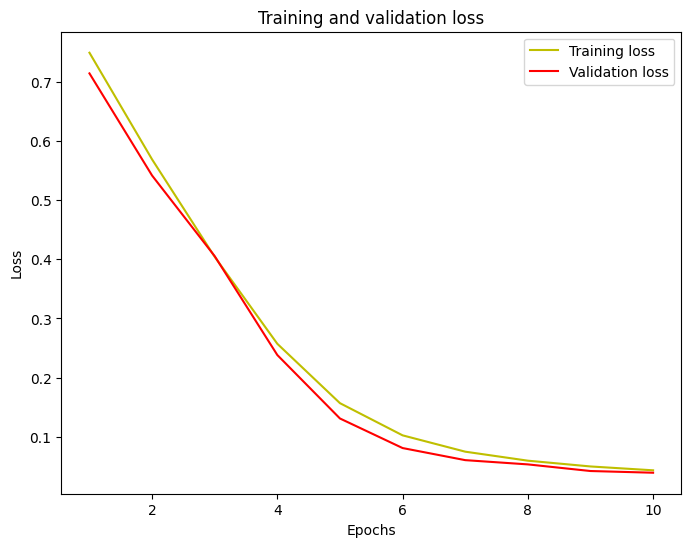

In [31]:
# ------------------- Plot Training Metrics -------------------
import matplotlib.pyplot as plt  # Add this import
# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, 'y', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 📊 Interprétation du graphique : Training and Validation Loss

Le graphique ci-dessus montre l’évolution de la **perte (loss)** pour l'ensemble **d'entraînement** (courbe jaune) et de **validation** (courbe rouge) sur **10 époques**.

### 🔍 Observations :

- **Diminution constante** : Les deux courbes (training et validation loss) diminuent de manière constante à mesure que les époques augmentent, indiquant que le modèle apprend efficacement.
- **Proximité des courbes** : La perte de validation suit de très près la perte d'entraînement, ce qui est un **bon signe de généralisation** — le modèle ne semble pas surajuster (overfitting) les données d'entraînement.
- **Stabilisation** : Vers la fin (autour de l’époque 9-10), les courbes semblent se stabiliser, suggérant que le modèle atteint un bon point d’équilibre entre biais et variance.

### ✅ Conclusion :

Le modèle s'entraîne correctement avec une bonne capacité de généralisation sur les données de validation. Il n’y a pas de signe visible de surapprentissage ou de sous-apprentissage, ce qui suggère que les **hyperparamètres choisis (comme le taux d’apprentissage ou le nombre d’époques) sont appropriés** pour ce cas.


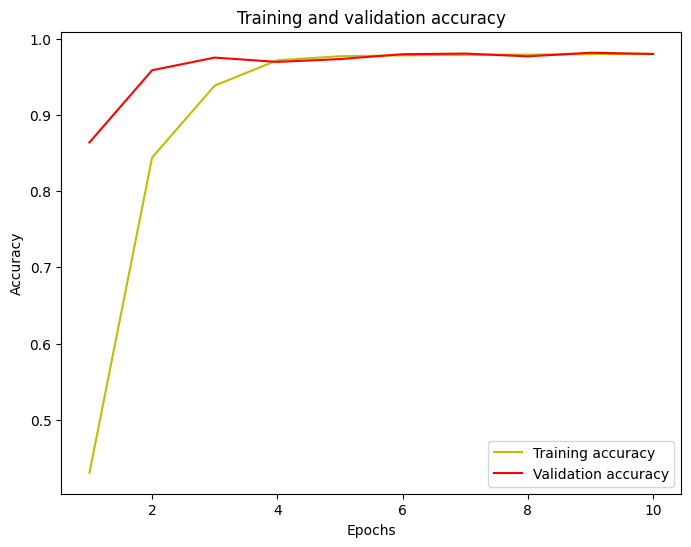

In [32]:
#Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, 'y', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



## 📈 Interprétation du graphique : Training and Validation Accuracy

Le graphique ci-dessus illustre l’évolution de la **précision (accuracy)** sur les ensembles **d'entraînement** (courbe jaune) et de **validation** (courbe rouge) au cours de 10 époques.

### 🔍 Observations :

- **Montée rapide de la précision** : Dès les premières époques (1 à 3), la précision augmente fortement pour les deux ensembles.
- **Précision élevée** : Les courbes atteignent rapidement une précision proche de **100%**, ce qui indique que le modèle est très performant.
- **Validation supérieure au début** : Fait intéressant, la précision sur l’ensemble de validation est légèrement supérieure à celle de l’entraînement durant les premières époques, ce qui peut être dû à un **petit ensemble de validation** ou à une **meilleure représentativité** des données de validation.
- **Convergence** : À partir de l’époque 4, les courbes se rapprochent et se stabilisent autour d’une précision très élevée (~99%), ce qui indique une **excellente capacité de généralisation**.

### ✅ Conclusion :

Le modèle montre une **très bonne performance globale**, avec une précision stable et élevée sur les deux ensembles. Il n’y a pas de signe de surapprentissage, et la convergence rapide indique une **architecture efficace et bien paramétrée**.

---



Loading validation sample from: BraTS2020_Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\BraTS20_Training_104
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


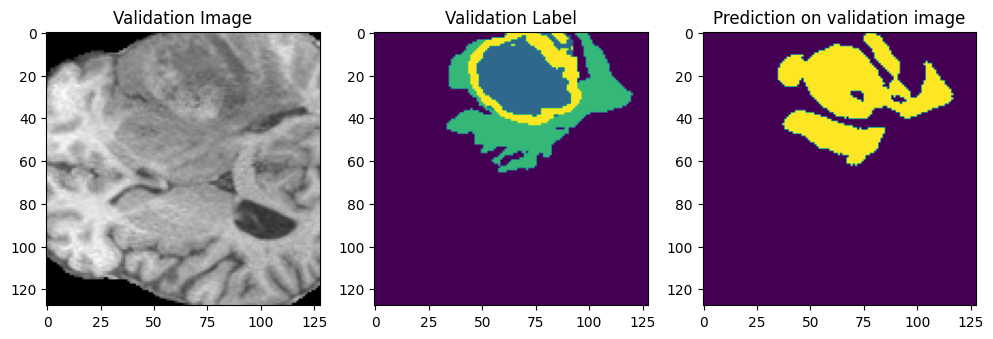

In [34]:
# ------------------- Prediction and Visualization -------------------
# Select a validation sample (since validation data has masks)
img_num = 7  # Using the first validation sample
if img_num < len(val_files):
    val_file = val_files[img_num]
    print(f"Loading validation sample from: {val_file}", flush=True)
    # Load and preprocess validation image
    flair = load_and_preprocess_image(val_file, 'flair')
    t1 = load_and_preprocess_image(val_file, 't1')
    t1ce = load_and_preprocess_image(val_file, 't1ce')
    t2 = load_and_preprocess_image(val_file, 't2')
    val_img = np.stack([flair, t1, t1ce, t2], axis=-1)
    # Load and preprocess validation mask
    val_mask = load_and_preprocess_mask(val_file)
    val_mask_argmax = np.argmax(val_mask, axis=3)
    # Predict
    val_img_input = np.expand_dims(val_img, axis=0)
    val_prediction = model.predict(val_img_input)
    val_prediction_argmax = np.argmax(val_prediction, axis=4)[0, :, :, :]
    # Plot individual slices for verification
    n_slice = 58  # As per your example
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Validation Image')
    plt.imshow(val_img[:, :, n_slice, 1], cmap='gray')
    plt.subplot(232)
    plt.title('Validation Label')
    plt.imshow(val_mask_argmax[:, :, n_slice])
    plt.subplot(233)
    plt.title('Prediction on validation image')
    plt.imshow(val_prediction_argmax[:, :, n_slice])
    plt.show()
else:
    print(f"Error: img_num {img_num} is out of range for validation files (max index: {len(val_files)-1}).", flush=True)

## 🧠 Interprétation du Résultat : Prédiction sur une Image de Validation

L’image ci-dessus montre le résultat d'une prédiction de segmentation sur un échantillon de l’ensemble de validation, avec trois sous-figures :

### 📷 1. Validation Image (à gauche)  
Il s'agit de l’image IRM brute utilisée comme entrée pour le modèle. Elle présente une coupe transversale du cerveau avec un bon contraste anatomique.

### 🏷️ 2. Validation Label (au centre)  
Ce masque représente les **annotations réelles (vérité terrain)**, c’est-à-dire les régions d’intérêt annotées manuellement (ou par un expert). Les différentes classes sont codées par des couleurs distinctes :
- Fond (violet foncé),
- Structures ou tissus cibles (jaune, vert...).

### 🤖 3. Prediction on Validation Image (à droite)  
Cette image affiche la **prédiction générée par le modèle**. Elle montre la sortie du modèle de segmentation appliquée à l'image d'entrée.  
La correspondance visuelle entre la prédiction et le label suggère une **bonne performance du modèle**, notamment :
- Les régions segmentées suivent fidèlement les contours réels.
- Peu de faux positifs ou faux négatifs visibles à l'œil nu.

### ✅ Conclusion :

Le modèle semble être **capable de segmenter correctement les structures cérébrales** à partir des images IRM. La qualité visuelle des prédictions montre une forte concordance avec les annotations réelles, ce qui est un **indicateur positif de sa précision et robustesse**.

---

